# 回帰分析

## §1. 線形回帰（単回帰）
変数$x$から目的の変数である$y$を説明する。

$$
y_i=a_0 + a_1 x_i + e_i
$$

ここで$e_i$は予測誤差であり、説明変数だけでは説明できない部分を表す。求めたい・知りたい情報は、$a_0$と$a_1$であり、最小二乗法を用いることで求めることができる。

### ex.1

In [1]:
import pandas as pd
print("pandas : version", pd.__version__)

import numpy as np
import matplotlib.pyplot as plt

# 教科書通りに、index に x, y を割り振ると、処理が面倒 （途中で transpose しなければならない）
# そのため、columns に x, y を割り振っている
df = pd.DataFrame({
          "x" :  [73, 63, 31, 24, 79, 84, 32, 33, 66, 36], 
          "y" : [37, 27, 18, 11, 39, 40, 14, 18, 28, 17]},
)
df

pandas : version 1.0.3


,x,y
0,73,37
1,63,27
2,31,18
3,24,11
4,79,39
5,84,40
6,32,14
7,33,18
8,66,28
9,36,17


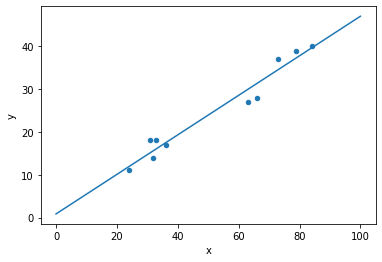

In [2]:
# axis=0 : 列方向、axis=1 行方向
x_bar, y_bar = df.mean()[0], df.mean()[1]

# pandas 1.1 未満は cov は不偏分散を返す
# そのため、N-1/N に相当する 0.9 を掛けて、通常の分散に直す必要がある
s_xx, s_xy = df.cov().iloc[0,0]*0.9, df.cov().iloc[0, 1]*0.9

a_hat_1 = s_xy/s_xx
a_hat_0 = y_bar - a_hat_1 * x_bar

x_lin = np.linspace(0,100, 100)

df.plot.scatter(x="x", y="y")
plt.plot(x_lin, a_hat_0 +  a_hat_1*x_lin)

###  scikit-learn. linear_model. LinearRegressionの使用

scipy の最小二乗法の実装（scipy.linalg.lstsq）を使用している。

0.46163394979907 0.8488712154684492


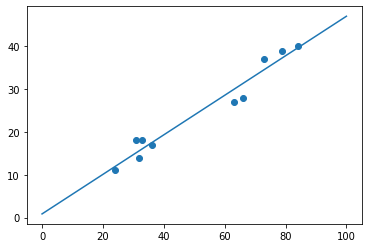

In [3]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()

# そのまま df["x"] を引数に与えると、ValueError: Expected 2D array, got 1D array instead:　と怒られる
# df["x"].shape = (10,) の1次元配列であるが、2次元配列（n行1列のデータ, 縦ベクトル）として与えなければならない
# x ... 2次元ベクトル（縦ベクトル）
# y ... 1次元ベクトル
slr.fit(df[["x"]].values, df["y"].values)

x_test = np.linspace(0,100,100).reshape(-1,1)
y_pred = slr.predict(x_test)

plt.scatter(df["x"], df["y"])
plt.plot(x_test, y_pred)

print(slr.coef_[0], slr.intercept_)

### scipy. least_squares

scipy.least_squares では以下の式を最小化することを目的とする。
$$
\frac{1}{2} \sum_{i=1}^n \left(\rho (f_i (x)^2 \right)
$$
ここで、$f(x)$は残差（residual)、$\rho(\cdot)$は損失関数 (loss function) を表す。損失関数を用いることで、残差の外れ値の影響を吸収している。`least_squares`では様々な損失関数に対応していて、デフォルトは linear（デフォルト設定）：$\rho(z)=z$であり、一般的な最小二乗法を表す。

In [5]:
from scipy.optimize import least_squares
import numpy as np

#  第一引数に対して最小化を行う
def func(p, x, y):
    return y-(p[1]*x+p[0])

# func : 残差
# [0, 0] : パラメーター（傾き、切片）の初期値を指定
# args : 訓練用データ
results = least_squares(func, [0,0], args=(df["x"], df["y"]))
print(results.x[0], results.x[1])

0.8488712154684471 0.46163394979907013


## §5. 線形重回帰

説明変数が複数ある場合、目的変数は：
$$
y_i = a_0 + a_1 x_1 + a_2 x_2 + ... a_p x_p
$$
として表すことができる。これを線形重回帰モデルと呼ぶ。重回帰の場合には、$(x_0,...,x_p), y$の$p+1$次元空間におけるデータを超平面で説明することとなる。

重回帰分析も単回帰分析と同様、予測誤差の平方和が最小となるようにパラメータ（$a_0...a_p$）を推定する。ただし単回帰の場合と異なり、それぞれの係数で偏微分した$p$元連立方程式を解くこととなる。

In [6]:
import pandas as pd
import numpy as np

df = pd.DataFrame( {
    "y" : [22, 36, 24, 22, 27, 29, 26, 23, 31, 24, 23, 27, 31, 25, 23],
    "x1" : [28, 46, 39, 25, 34, 29, 38, 23, 42, 27, 35, 39, 38, 32, 25],
    "x2" : [146, 169, 160, 156, 161, 168, 154, 153, 160, 152, 155, 154, 157, 162, 142],
    "x3" : [34, 57, 48, 38, 47, 50, 54, 40, 62, 39, 46, 54, 57, 53, 32],
})
df

,y,x1,x2,x3
0,22,28,146,34
1,36,46,169,57
2,24,39,160,48
3,22,25,156,38
4,27,34,161,47
5,29,29,168,50
6,26,38,154,54
7,23,23,153,40
8,31,42,160,62
9,24,27,152,39


`mlxtend`ライブラリを用いることで、データセットの特性を可視化することができる。これらはヒストグラムもしくは散布図であり、低レベルの情報を見ることができる。分析する前の重要な相関関係の把握を行うことができる（教科書のデータセットでは数が少ないのであまり有用ではないかもしれないが）。

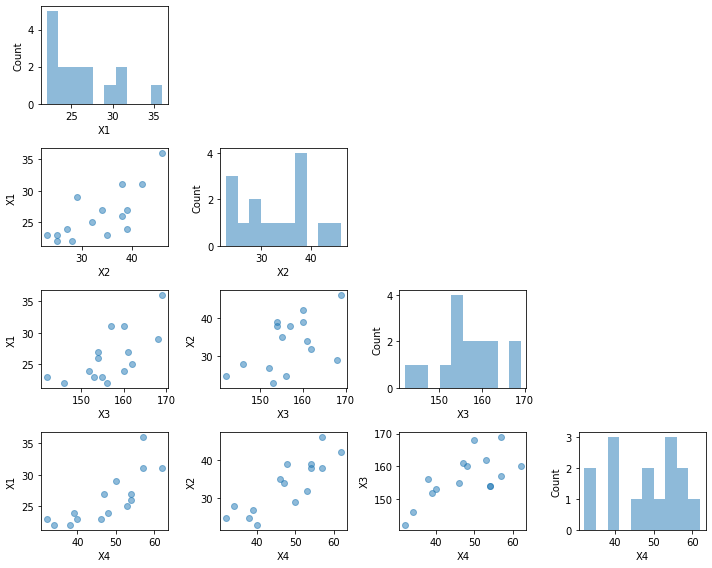

In [21]:
from mlxtend.plotting import scatterplotmatrix
scatterplotmatrix(df.values, figsize=(10, 8), alpha=0.5)
plt.tight_layout()

また重要な相関関係として、共分散行列が挙げられる。これは `pandas`から直接計算させることができる。

In [13]:
# 教科書で計算されているのは分散で、pandas が返すのは不偏分散
# そのため教科書の数字に合わせるために、N-1/N を掛けている
df.cov() * 14/15

# numpy でも同様に共分散行列を計算することができる。
# >>> np.cov(df.T, ddof=0)

,y,x1,x2,x3
y,15.226667,19.666667,18.680000,26.986667
x1,19.666667,45.422222,24.933333,50.066667
x2,18.680000,24.933333,48.773333,42.560000
x3,26.986667,50.066667,42.560000,77.040000


さらに、`mlxtend`ライブラリを用いると、共分散行列をヒートマップとして可視化することができる。

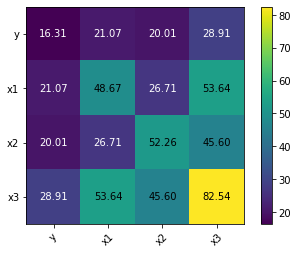

In [12]:
from mlxtend.plotting import heatmap
hm = heatmap(df.cov().values.T, row_names = df.columns, column_names = df.columns )

重回帰式のパラメータも`sklearn`を用いることで簡単に求めることができる。

In [30]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(df[["x1", "x2", "x3"]], df["y"])

print(slr.coef_)
print(slr.intercept_)

[0.20137689 0.17102457 0.12494278]
-13.217298316378507
